In [1172]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
import random

In [1173]:
def total_value(values):
    # return the number of pieces as they are all of equal value
    return len(values)

def cut_position(values, ratio):
    # return the whole cake in the special case where the user wants the whole cake
    if ratio == 1:
        return 1
    # calculate the desired number of pieces 
    slices_target = total_value(values) * ratio 
    # split the whole and fractional pieces for processing
    whole_pieces = int(slices_target)
    fractional_part = slices_target - whole_pieces
    # get the position of the last whole piece or zero where there are none
    position = values[whole_pieces - 1] if whole_pieces > 0 else 0
    # get the size of the next piece and add a fraction of that to the position
    next_jump = values[whole_pieces] - position
    position += fractional_part * next_jump
    # normalise and return the position
    return position / values[-1]

def evaluate(values, ratio):
    if ratio == 0:
        return 0
    # get the precise position of the end of the cut
    cut_position = values[-1] * ratio
    # get the pieces that come before the cut
    left_pieces = [x for x in values if x < cut_position]
    # get the whole number position as zero or the last piece that comes before the cut
    reference_point = left_pieces[-1] if left_pieces else 0
    # get the width of the first non-left slice
    next_slice_width = values[len(left_pieces)] - reference_point
    # get the fractional width of the piece
    partition_width = cut_position - reference_point
    # add the ratio of the fractinal piece to the number of whole piece
    total_width = len(left_pieces) + partition_width / next_slice_width
    # return the normalised evaluation
    return total_width / len(values)

def diff_cut(values, ratio, range):
    start_value = evaluate(values, range[0])
    end_value = evaluate(values, range[1])
    
    target_value = start_value + ratio * (end_value - start_value)
    position = cut_position(values, target_value)

    return range[0] + position * (range[1] - range[0])

def diff_eval (values, range):
    return evaluate(values, range[1]) - evaluate(values, range[0])


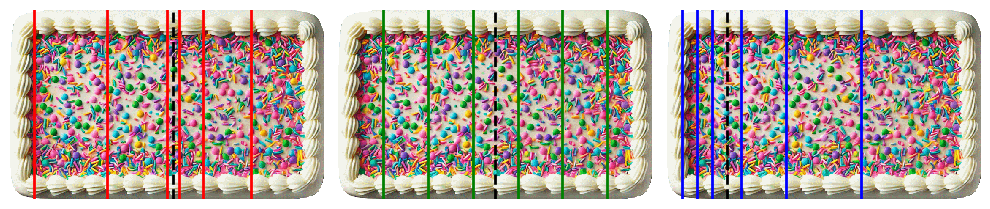

In [1236]:
# Initialise piecewise uniform values
values = [[1, 4, 6.5, 7, 8, 10, 13],
          [2, 4, 6, 8, 10, 12, 14],
          [1, 2, 3, 5, 8, 13, 21]]

# Declare array of colours for each value set
colors = ["red", "green", "blue"]

# Read in the cake image
cake = skimage.io.imread("cake.png") / 255.0

# Instantiate a figure
fig, axs = plt.subplots(1, len(values), figsize=(10, 5))

# Loop over the values array 
for idx, (value_set, ax) in enumerate(zip(values, axs)):
    ax.imshow(cake, cmap="gray", interpolation="nearest")
    ax.axis("off")

    # Declare the end of the image and the values
    pixel_width = cake.shape[1]
    slice_width = value_set[-1]

    # Plot a line for each equal value section
    for value in value_set[:-1]:
        position = pixel_width * (value / slice_width)
        ax.axvline(x=position, color= colors[idx], linestyle='-', linewidth=2)
    ax.axvline(x=pixel_width * (cut_position(value_set, 0.5) ), color="black", linestyle='--', linewidth=2)

# Display the figure with a tight layout
plt.tight_layout()
plt.show()



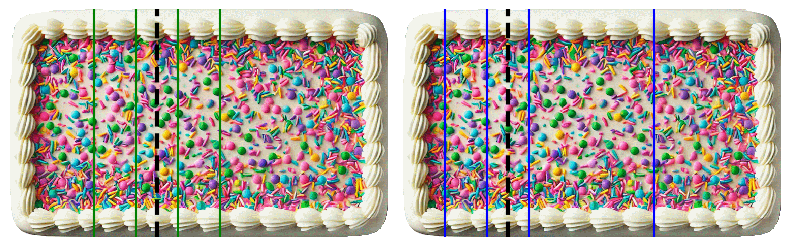

0.5 0.5
0.63 0.37


In [1238]:
# Two person cut and choose

x = [x/10 for x in sorted(random.sample(range(1, 11), 5))]
y = [x/10 for x in sorted(random.sample(range(1, 11), 5))]

x_cut_pos = cut_position(x, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, values, color in zip(axes, [x, y], ["green", "blue"]):
    ax.imshow(cake, cmap="gray", interpolation="nearest")
    ax.axis("off")
    ax.axvline(x=pixel_width * cut_position(values, 0.5), color="black", linestyle='--', linewidth=3)
    for value in values[:-1]:
        ax.axvline(x=pixel_width * (value / values[-1]), color=color, linestyle='-', linewidth=1.5)

plt.tight_layout()
plt.show()

print(round(evaluate(x, cut_position(x, 0.5)), 2), round(1 - evaluate(x, cut_position(x, 0.5)), 2))
print(round(evaluate(y, cut_position(x, 0.5)), 2), round(1 - evaluate(y, cut_position(x, 0.5)), 2))


In [1211]:
# three way selfridge-conway algorithm

# randomly generate three piecewise uniform value assignments
a, b, c = sorted(random.sample(range(1, 11), 5,)), sorted(random.sample(range(1, 11), 5,)), sorted(random.sample(range(1, 11), 5,))

# generate three slices of equal value according to agent a
initial_cuts = 0, cut_position(a, 1/3), cut_position(a, 2/3), 1
initial_slices = [(initial_cuts[i], initial_cuts[i+1]) for i in range(len(initial_cuts)-1)]

# generate evaluations from the perspective of agent b
initial_evaluations = [diff_eval(b, x) for x in initial_slices]

print(initial_evaluations)

highest_piece = np.argsort(initial_evaluations)[-1]
second_highest_piece = np.argsort(initial_evaluations)[-2]
second_highest_value = initial_evaluations[second_highest_piece]

print(second_highest_value)

for i in range(len(initial_slices)):
    print(f"{i}: {initial_slices[i]} = {initial_evaluations[i]}")

trim_start = cut_position(b, second_highest_value + evaluate(b, initial_slices[highest_piece][0]))



trim = trim_start, initial_slices[np.argsort(initial_evaluations)[-1]][1]


print(second_highest_value)
print(diff_eval(b, trim) / 3)

print("Total; " + str(second_highest_value + diff_eval(b, trim) / 3))
print("sliceslice; " + str( + diff_eval(b, trim) / 3))

initial_slices[highest_piece] = initial_slices[highest_piece][0], trim_start

c_slice = np.argmax([evaluate(c,slice[1]) - evaluate(c,slice[0]) for slice in initial_slices])

initial_allocations = [-1, -1, -1]
initial_allocations[2] = int(c_slice)


if c_slice == highest_piece:
    agent_t, agent_t_hat = 2,1
    initial_allocations[1] = int(second_highest_piece)
    initial_allocations[0] = [value for value in [0,1,2] if value not in initial_allocations][0]
else:
    agent_t, agent_t_hat = 1,2
    initial_allocations[1] = int(highest_piece)
    initial_allocations[0] = [value for value in [0,1,2] if value not in initial_allocations][0]


secondary_cuts = trim[0], diff_cut([a,b,c][agent_t_hat], 1/3, trim), diff_cut([a,b,c][agent_t_hat], 2/3, trim), trim[1]
secondary_slices = [(secondary_cuts[i], secondary_cuts[i+1]) for i in range(len(secondary_cuts)-1)]

print([diff_eval(b, x) for x in secondary_slices])

print(agent_t)

secondary_allocations = np.zeros(3, dtype=object)
remaining_slices = secondary_slices.copy()

for agent in [agent_t, 0, agent_t_hat]:
    preferences = [diff_eval([slice][0] if isinstance(slice, list) else slice, x) 
                   for x in remaining_slices]
    best_slice_index = np.argmax(preferences)
    
    secondary_allocations[agent] = remaining_slices[best_slice_index]
    remaining_slices[best_slice_index] = (1, 0)

initial_allocations = [initial_slices[x] for x in initial_allocations]

print(diff_eval(a, initial_allocations[0]) + diff_eval(a, secondary_allocations[0]))
print(diff_eval(b, initial_allocations[1]) + diff_eval(b, secondary_allocations[1]))
print(diff_eval(c, initial_allocations[2]) + diff_eval(c, secondary_allocations[2]))





[0.08333333333333333, 0.11666666666666663, 0.8]
0.11666666666666663
0: (0, 0.20833333333333331) = 0.08333333333333333
1: (0.20833333333333331, 0.4999999999999999) = 0.11666666666666663
2: (0.4999999999999999, 1) = 0.8
0.11666666666666663
0.22777777777777775
Total; 0.3444444444444444
sliceslice; 0.22777777777777775
[0.4410185185185185, 0.09999999999999998, 0.14231481481481478]
1
0.39025925925925914
0.5576851851851853
0.32532407407407404


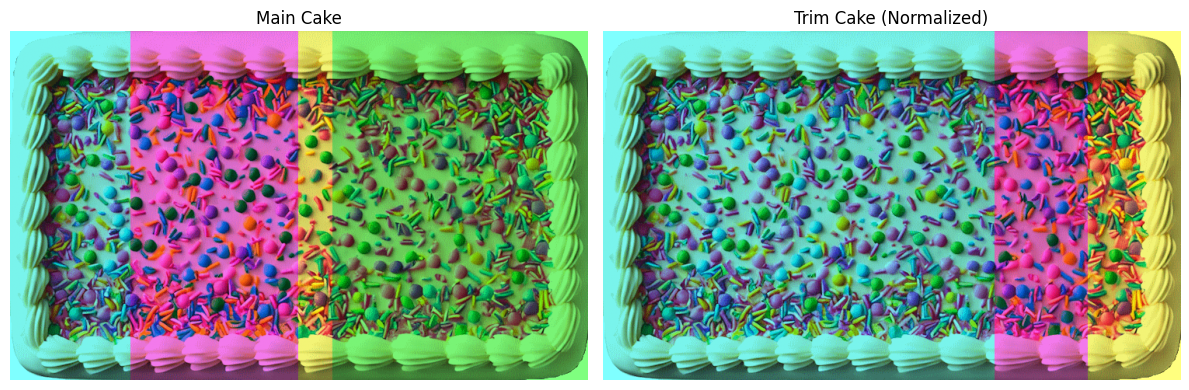

In [1212]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming trim and secondary_slices are already defined

# Define the width of the cake (image width)
pixel_width = cake.shape[1]

# Copy the cake image
new_cake = cake.copy()

# Apply initial slices to the cake
new_cake[:, (int(pixel_width * initial_slices[0][0])):int((pixel_width * initial_slices[0][1])), 0] *= 1/2
new_cake[:, (int(pixel_width * initial_slices[1][0])):int((pixel_width * initial_slices[1][1])), 1] *= 1/2
new_cake[:, (int(pixel_width * initial_slices[2][0])):int((pixel_width * initial_slices[2][1])), 2] *= 1/2

# Apply the trim area to the cake
new_cake[:, (int(pixel_width * trim[0])):int((pixel_width * trim[1])), 0] *= 0.5
new_cake[:, (int(pixel_width * trim[0])):int((pixel_width * trim[1])), 2] *= 0.5

# Normalize the secondary slices relative to the trim area
normalized_secondary_slices = [
    ((slice[0] - trim[0]) / (trim[1] - trim[0]), (slice[1] - trim[0]) / (trim[1] - trim[0]))
    for slice in secondary_slices
]

# Create a new cake for the normalized trim (Trim Cake)
new_cake_trim = cake.copy()

# Apply normalized secondary slices to the cake, based on the trim
new_cake_trim[:, (int(pixel_width * normalized_secondary_slices[0][0])):int((pixel_width * normalized_secondary_slices[0][1])), 0] *= 1/2
new_cake_trim[:, (int(pixel_width * normalized_secondary_slices[1][0])):int((pixel_width * normalized_secondary_slices[1][1])), 1] *= 1/2
new_cake_trim[:, (int(pixel_width * normalized_secondary_slices[2][0])):int((pixel_width * normalized_secondary_slices[2][1])), 2] *= 1/2

# Plot the Main Cake and the Trim Cake side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot Main Cake on the first subplot
axs[0].imshow(new_cake)
axs[0].set_title("Main Cake")
axs[0].axis("off")

# Plot Trim Cake on the second subplot
axs[1].imshow(new_cake_trim)
axs[1].set_title("Trim Cake (Normalized)")
axs[1].axis("off")

# Show the plots
plt.tight_layout()
plt.show()


agent A, agent B, agent C

Green is the trim piece

In [ ]:
# Dubins-Spanier

random_array = np.random.randint(1, 11, size=(8, 5))
random_array = np.sort(random_array, axis=1)

complete = [0,0,0,0,0,0,0,0]

position = 0


ratio = np.count_nonzero(type(complete) == int)
print(ratio)

evaluations = [diff_cut(x, 0.125, (position,1)) for idx, x in enumerate(random_array) if complete[idx] == 0]
winner = np.argmin(evaluations)
complete[winner] = [position, evaluations[winner]]
position = evaluations[winner]
ratio = np.count_nonzero(complete == 0)
print(ratio)

complete

0
0


[0, 0, 0, 0, [0, np.float64(0.0625)], 0, 0, 0]